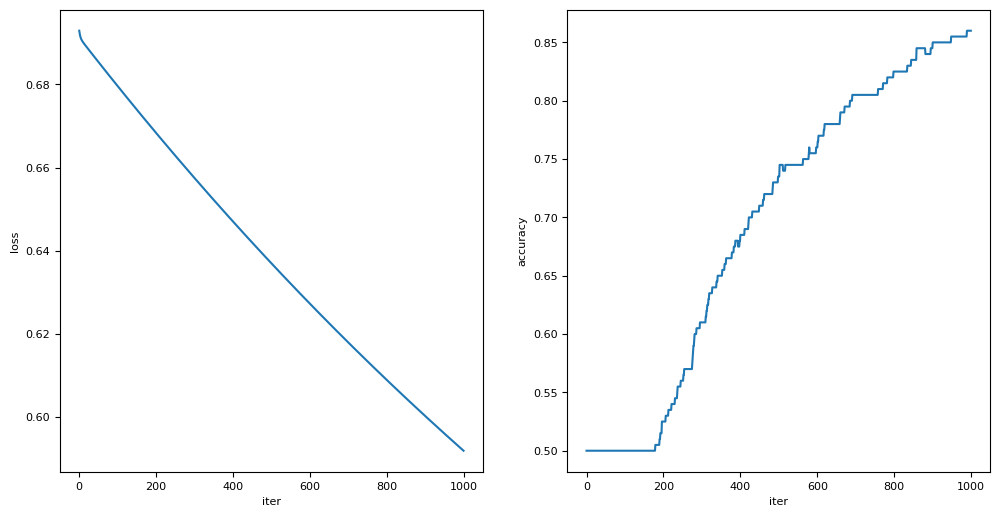

C:\Users\jayanti.prasad\AppData\Local\Temp\ipykernel_10784\516111816.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bias'] = np.ones(df.shape[0])
C:\Users\jayanti.prasad\AppData\Local\Temp\ipykernel_10784\516111816.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bias'] = np.ones(df.shape[0])


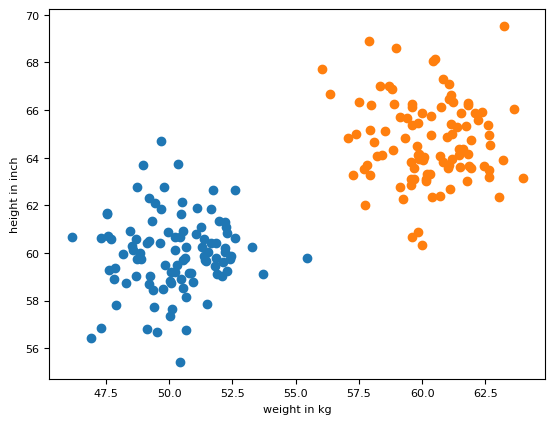

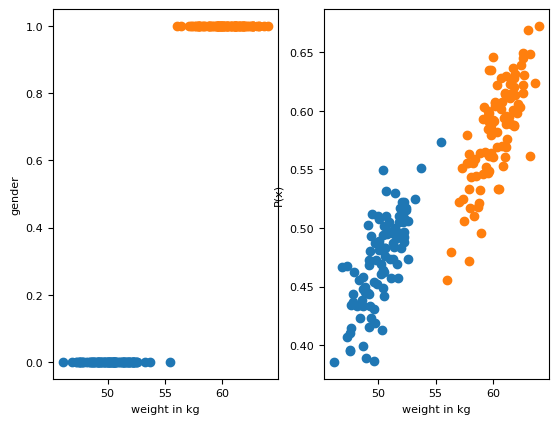

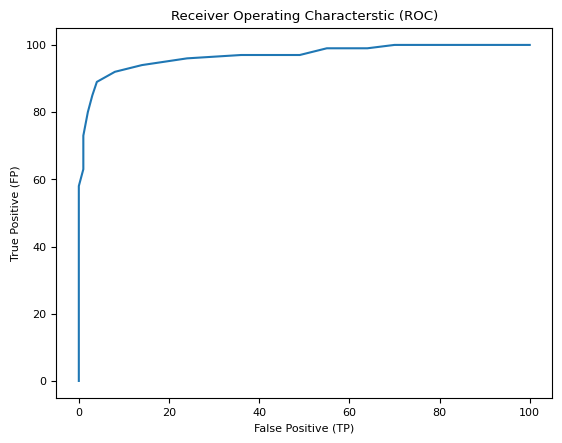

In [19]:
import os
import sys
import argparse
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt


#create the data or read 
def get_data ():
   # two dimensional gaussian data 
   cov = [[3, 0.25], [0.25, 3]]
   x1 = np.random.multivariate_normal((50, 60), cov,100)
   x2 = np.random.multivariate_normal((60, 65), cov,100)
   df = pd.DataFrame(columns=['weight','height','gender'])
   count = 0
   for i in range(0, len(x1)):
      df.loc[count] = [x1[i,0], x1[i,1], 0]
      count +=1
   for i in range(0, len(x2)):
      df.loc[count] = [x2[i,0], x2[i,1], 1]
      count +=1
   return df.sample(frac=1) 


def df2np (df):
   # Note that we have added one extra feature columns of 1s
   # so that the bias term can also be incorporated in the 
   # weights 
   # y = w x + b can be writen as 
   # y = W X, with (W=(w,b) and X = (x,1)

   df['bias'] = np.ones(df.shape[0])
   X = df[['bias','weight','height']].to_numpy()
   y = df[['gender']].to_numpy()
   return X, y 

# these are function which can be used outside also

def sigmoid (w, x):
    y = np.dot (w, x)
    return 1.0/(1.0 + np.exp(-y))

def loss(h, y):
   ce =  np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h))
   return ce/y.shape[0]


def score(y, y_p):
    y = y.reshape (y.shape[0])
    y = np.array([int(t) for t in y])
    TP, FP, TN, FN = 0,0,0,0
    for i in range (0, y.shape[0]):
       if y[i] == 1:
           if y_p[i] == 1:
             TP +=1
           else:
             FN +=1
       else :
           if y_p [i] == 1:
             FP +=1
           else:
             TN +=1     
    accuracy = (TP+TN)/(TP+FP+TN+FN)            
    return {'TP':TP,'TN':TN,'FP':FP,'FN':FN,'acc':accuracy} 


# This is the main class 

class LogReg:
   def __init__(self, ndim, max_iter=1000, lr=0.0007):
      self.ndim = ndim 
      self.w = np.random.random([ndim])/1000.0
      self.iter = max_iter 
      self.lr = lr  
      self.thrs = 0.5   
 
   def fit(self, x, y):
      y = y.reshape(y.shape[0])       
      history = pd.DataFrame (columns=['iter','loss','acc']) 
      for i in range (0, self.iter):
          h = self.predict (x)
          grad = np.dot (X.T, h-y) /y.shape[0]
          self.w  -= self.lr * grad 
          y_hat = [0 if p < self.thrs else 1 for p in h]
          S = score(y, y_hat) 
          history.loc[i] = [i,  loss(h,y),S['acc']]
      return history   
   
   def predict (self, x):
      h = np.array ([sigmoid (self.w, x[i,:])\
         for i in range(0, x.shape[0])])
      return h  

   def predict_class (self, x, p_cut):
      h = self.predict (x)
      y = [0 if p < p_cut else 1 for p in h]
      return np.array(y)


def plot_data(df, model, outdir):
    
    # separate the input data on the basis of class
    # for the purpose of plotting 
    df1 = df[df['gender'] == 0.0]
    df2 = df[df['gender'] == 1.0]

    x_f, y_f = df2np (df1)
    x_m, y_m = df2np (df2)

    # plot the input data (features)
    plt.scatter(x_f[:,1],x_f[:,2])
    plt.scatter(x_m[:,1],x_m[:,2])
    plt.xlabel('weight in kg')
    plt.ylabel('height in inch')
    plt.savefig(outdir + os.sep + "gender_input.pdf")

    # now make the predictions  
    # (for the training data itself)

    h_f =  model.predict (x_f)
    h_m =  model.predict (x_m)

    # now plot the actual class label for one
    # of the features  
    plt.rcParams.update({'font.size': 8})
    fig, (ax1, ax2) = plt.subplots(1,2)

    ax1.plot(x_f[:,1], y_f,'o')
    ax1.plot(x_m[:,1], y_m,'o')
    ax1.set_xlabel('weight in kg')
    ax1.set_ylabel('gender')
  
    # plot the probabilities sigmoid (x) for 
    # one of the features 
    ax2.plot(x_f[:,1], h_f,'o')
    ax2.plot(x_m[:,1], h_m,'o')
    ax2.set_xlabel('weight in kg')
    ax2.set_ylabel('P(x)')
    #fig.savefig(outdir + os.sep + "gender_output.pdf")
    plt.show()   
    #plt.clf()


def plot_roc(X, model, outdir):
    p  =  np.arange(0.1,0.9,0.01)

    df_roc = pd.DataFrame (columns=["threshold","true_positive",\
       "false_positive","true_negative","false_negative"])

    count = 0
    tp = []
    fp = []
    for p_cut in p:
       y_p  = model.predict_class (X, p_cut=p_cut)
       sc = score (y, y_p)
       t = "{:10.2f}".format(p_cut)
       df_roc.loc[count] = [t, sc['TP'], sc['FP'], sc['TN'],sc['FN']]
       tp.append (sc['TP'])
       fp.append (sc['FP'])
       count +=1

     #print(p_cut, sc)

    df_roc.to_csv(outdir + os.sep + "roc.csv")
    plt.plot(fp, tp)
    plt.title("Receiver Operating Characterstic (ROC)")
    plt.xlabel("False Positive (TP)")
    plt.ylabel("True Positive (FP)")
    #plt.savefig(outdir + os.sep + "roc.pdf")
    plt.show()
    

# Main calling program 

if __name__ == "__main__":
 
    # Read the parameters  
    niter = 1000 

    learning_rate = 0.0001
    # create output directory if does not exist 
    outdir = "tmp"
    os.makedirs(outdir, exist_ok=True)

    # get the data 
    df = get_data ()

    df.to_csv(outdir + os.sep + "gender.csv")

    # convert data to numpy arrays
    X, y = df2np (df)

    # This is the model object 
    model = LogReg (X.shape[1], niter, learning_rate)

    # Fit the data 
    df_h = model.fit(X, y)

    fig, axs = plt.subplots (1,2,figsize=(12,6))
    axs[0].plot(df_h['iter'], df_h['loss'])
    axs[1].plot(df_h['iter'], df_h['acc'])
    axs[0].set_xlabel('iter')
    axs[0].set_ylabel('loss')
    axs[1].set_xlabel('iter')
    axs[1].set_ylabel('accuracy')
    plt.show()
    
    plot_data (df, model, outdir)

    plot_roc (X, model, outdir)
    #yhat = model.predict_class (X, 0.5)
    #print(yhat)